# Pseudomonas

A notebook for the exploration of Pseudomonas.

Note that we use our data from the Autoencoding for this, but we have already calculated and stored that data so we can reload it here!

## Set up and reading the data

In [1]:
import os
import sys
from socket import gethostname

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib


In [2]:
sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")

In [3]:
outdir = 'pseudomonas'
os.makedirs(outdir, exist_ok=True)

### Read the autoencoder

In [4]:
encoder_models = 'cluster_gbrfs'
if not os.path.exists(os.path.join(encoder_models, 'clusters.json')):
    print("Please run the autoencoder code before trying to load the models.", file=sys.stderr)
    exit(1)

if not os.path.exists(os.path.join(encoder_models, 'pc_df.tsv')):
    print("Please create and save the PCA before trying to load the models.", file=sys.stderr)
    exit(1)

with open(os.path.join(encoder_models, 'clusters.json'), 'r') as file:
    data = json.load(file)
tmpjsondf = pd.DataFrame(list(data.items()), columns=['Cluster', 'Feature'])
cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
cluster_assignments['Cluster'] = cluster_assignments['Cluster'].astype(int)

pc_df = pd.read_csv(os.path.join(encoder_models, 'pc_df.tsv'), sep="\t", index_col=0)

## Run the Gradient Boosted Random Forest

We used 349 estimators for the random forest classifier


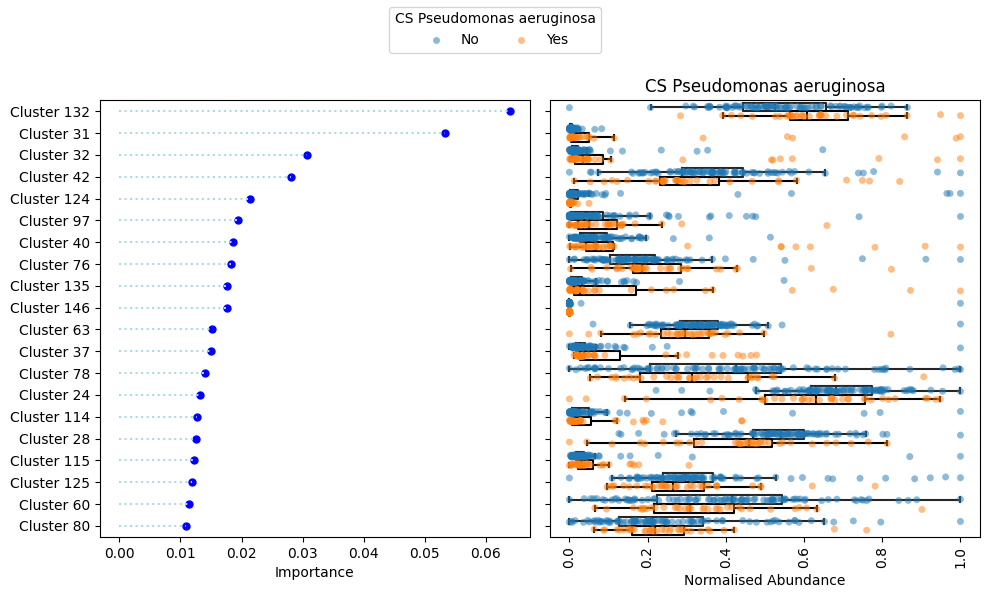

In [8]:
#intcol = 'Pseudomonas Culture' # note these two columns have the same information, but 'CS_Pseudomonas aeruginosa' is a category, while 'Pseudomonas culture' is a float!
intcol = 'CS_Pseudomonas aeruginosa'

intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y, n_estimators=1000, n_iter_no_change=20)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
cf_analysis_lib.plot_one_top_feature(merged_df, feature_importances_sorted, intcol, intcol_title, custom_labels)

In [ ]:
X.shape

# ROC Curve for Pseudomonas using these clusters


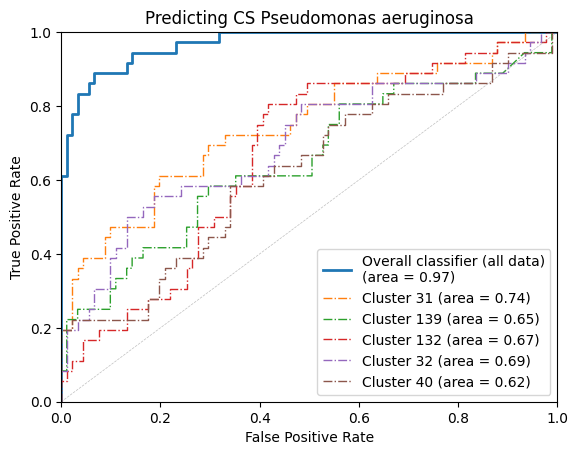

In [6]:
plt = cf_analysis_lib.plot_roc_curves(model, X, y, feature_importances_sorted, met, intcol_title)
plt.show()

# MDR Peudomonas

The MDR Pseudomonas is a subset of the Pseudomonas - all the entries for MDR culturing also have regular Pseudomonas, so what makes them different?

In [7]:
metadata[metadata['CS_MDR_Pseudomonas aeruginosa'] == 1][['CS_Pseudomonas aeruginosa', 'CS_MDR_Pseudomonas aeruginosa']]

,CS_Pseudomonas aeruginosa,CS_MDR_Pseudomonas aeruginosa
NAME,,
1282052_20180206_S,1,1
1316935_20180417_S,1,1
1465461_20180406_S,1,1
1565754_20180403_S,1,1
1588281_20180508_S,1,1
1593967_20180424_S,1,1
1593973_20180427_S,1,1
1593973_20180504_S,1,1
658355_20180321_S,1,1


'CS_MDR_Pseudomonas aeruginosa' has samples from 14 pwCF


Mean squared error for CS_MDR_Pseudomonas aeruginosa using classifier is 0.25


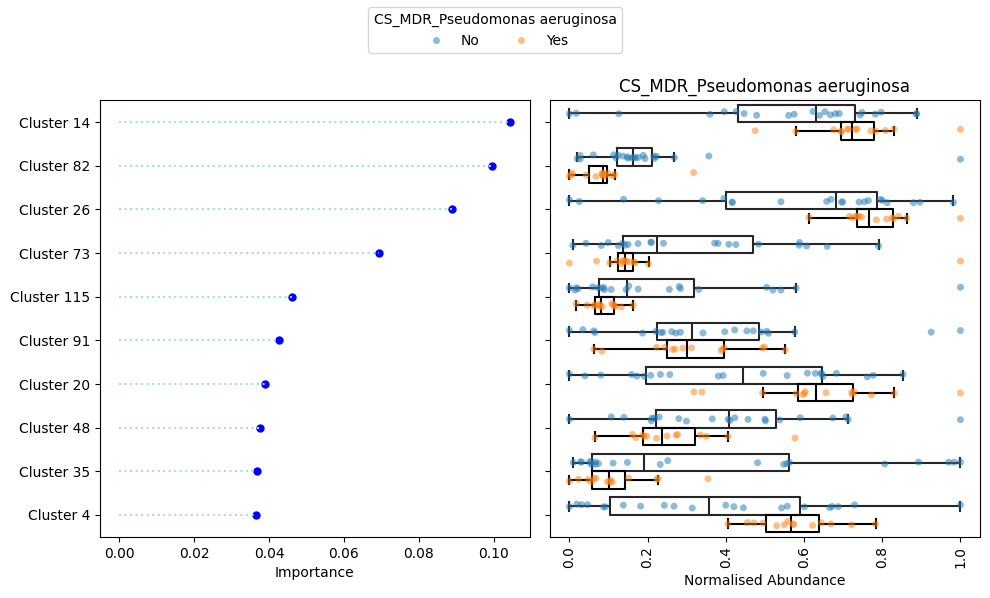

In [8]:
intcol = 'CS_MDR_Pseudomonas aeruginosa'
print(f"'{intcol}' has samples from {metadata.groupby(intcol).size()[1]} pwCF")


# set up our titles and the filename
intcol_title = replace_index.sub('', intcol)
intcol_filename = intcol.replace(" ", "_")

# we limit this to only those samples that ALSO have Pseudomonas, so now we can see if any clusters discriminate regular from MDR Pseudomonas.
merged_df = pc_df.join(metadata[metadata['CS_Pseudomonas aeruginosa'] == 1][intcol], how='inner').dropna(subset=intcol)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)
if categorical_data is None:
    print(f"Error: {intcol} is not a numeric or categorical column. Skipped", file=sys.stderr)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

met = None
if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'


print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)

y_features = 10
topN = list(feature_importances_sorted[:y_features].index) + [intcol]
fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=2, sharey='row', sharex='col')
cf_analysis_lib.plot_feature_importance(axes[0], feature_importances_sorted[:y_features][::-1], "")
cf_analysis_lib.plot_feature_abundance(axes[1], merged_df[topN][::-1], intcol, intcol_title)

handles, labels = axes[1].get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = labels
try:
    updated_labels = [custom_labels[float(label)] for label in labels]
except Exception as e:
    print(f"Couldn't update labels {e}.", file=sys.stderr)

for ax in axes.flat:
    if ax.get_legend() is not None:  # Check if legend exists
        ax.get_legend().remove()

plt.xticks(rotation=90)
fig.legend(handles, updated_labels, loc='upper center', ncol=2, title=intcol_title)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


### ROC Curve for Predicting MDR

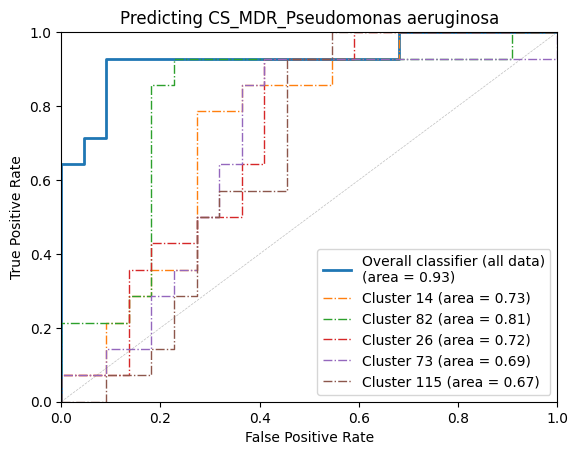

In [9]:
plt = cf_analysis_lib.plot_roc_curves(model, X, y, feature_importances_sorted, met, intcol_title)
plt.show()

'CS_MDR_Pseudomonas aeruginosa' has samples from 14 pwCF


Wrote the new image to pseudomonas/img/clusters_manual/CS_MDR_Pseudomonas_aeruginosa_Cluster_82.png


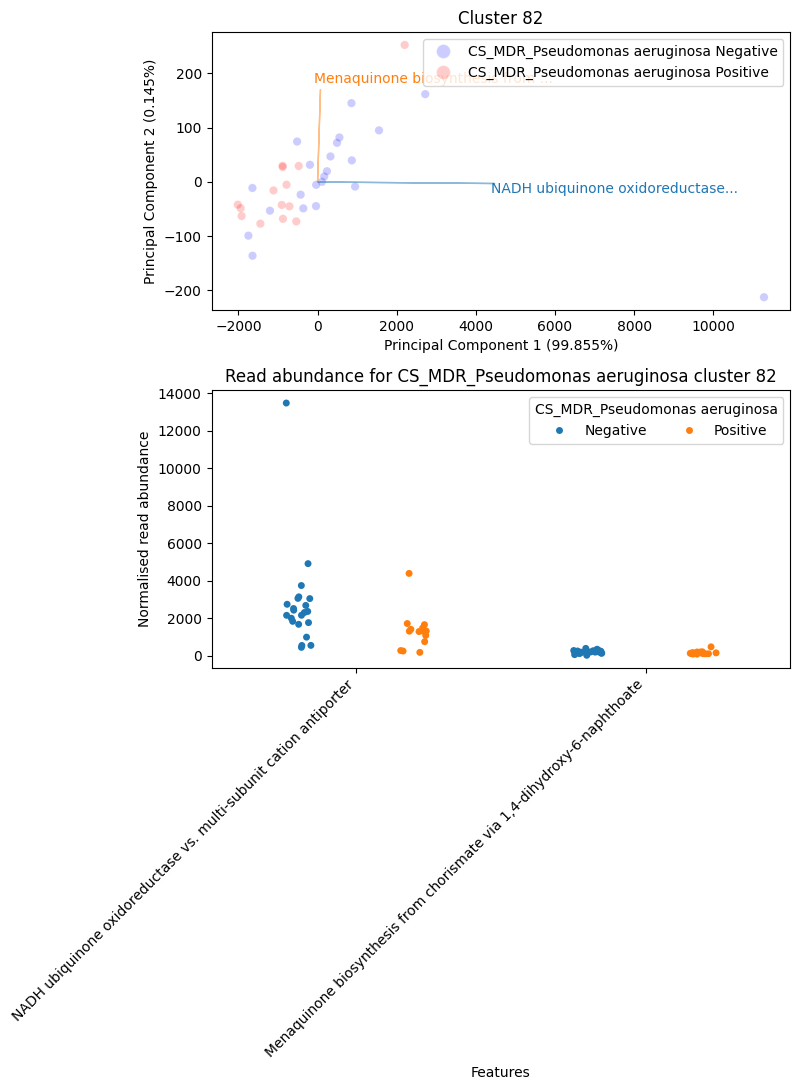

In [10]:
interesting_cluster = 82
print(f"'{intcol}' has samples from {metadata.groupby(intcol).size()[1]} pwCF")

if isinstance(interesting_cluster, int):
    interesting_cluster_filename = f"Cluster_{interesting_cluster}"
elif 'Cluster' in interesting_cluster:
    interesting_cluster_filename = interesting_cluster.replace(" ", "_")
else:
    interesting_cluster_filename = f"Cluster_{interesting_cluster}"
intcol_filename = intcol.replace(" ", "_")
intcol_filename = replace_nonword.sub('', intcol_filename)


# make a new dir so we don't overwrite!
os.makedirs(os.path.join(outdir, "img", "clusters_manual"), exist_ok=True)

pca = PCA(n_components=2)
int_cluster_num = interesting_cluster

df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == int_cluster_num, "Feature"]]
# limit to only those that also have Pseudomonas
merged_df_clust = df_clust.join(metadata[metadata['CS_Pseudomonas aeruginosa'] == 1][intcol], how='inner')
df_clust = merged_df_clust.drop(intcol, axis=1)

pca_result = pca.fit_transform(df_clust)
pca_df = pd.DataFrame(data=pca_result, index=df_clust.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=df_clust.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()

explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]

# don't forget to change the legend
intcol_neg = 0

colours = np.where(merged_df_clust[intcol] == intcol_neg, 'blue', 'red')

# Plot the PCA results
fig, axes = plt.subplots(figsize=(8, 11), nrows=2, ncols=1)
ax = axes[0]
sns.scatterplot(data=pca_df, x='PC1', y='PC2', alpha=0.2, c=colours, ax=ax)
ax.set_title(f"Cluster {interesting_cluster}")
ax.set_xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
ax.set_ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 5
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)


for i in range(maxloadings):
    c = next(colour_cycle)
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    ax.arrow(0, 0, xpos, ypos, 
              color=c, alpha=0.5, width=0.05)
    loading_text = top_loadings_df.index[i]
    if len(loading_text) > 30:
        loading_text = loading_text[:30] + "..."
    texts.append(ax.text(xpos, ypos, loading_text, color=c))

adjust_text(texts, ax=ax)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'{intcol} Negative', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'{intcol} Positive', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
ax.legend(handles=[blue_patch, red_patch])

## Read abundance
ax = axes[1]

df_clust_m = merged_df_clust.melt(id_vars=intcol, var_name='Features', value_name='Normalised read abundance')
df_clust_m = df_clust_m[df_clust_m['Normalised read abundance'] > 0]

cl = {'IP': 'red', 'OP': 'blue'}
g = sns.stripplot(data=df_clust_m, x='Features', y='Normalised read abundance', hue=intcol, dodge=True, jitter=True, ax=ax)
custom_labels = {0: 'Negative', 1: 'Positive'}
handles, labels = g.get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = [custom_labels[float(label)] for label in labels]
g.get_legend().remove()
g.legend(handles, updated_labels, loc='upper right', ncol=2, title=intcol_title)

ax.tick_params(axis='x', rotation=45)
for label in ax.get_xticklabels():
    label.set_horizontalalignment('right')
ax.set_title(f"Read abundance for {intcol} cluster {interesting_cluster}")


plt.tight_layout()
plt.savefig(os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}.png"))
print(f'Wrote the new image to {os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}.png")}', file=sys.stderr)
# Show the plot
plt.show()

In [11]:
interesting_cluster = 82
print(f"'{intcol}' has samples from {metadata.groupby(intcol).size()[1]} pwCF")

if isinstance(interesting_cluster, int):
    interesting_cluster_filename = f"Cluster_{interesting_cluster}"
elif 'Cluster' in interesting_cluster:
    interesting_cluster_filename = interesting_cluster.replace(" ", "_")
else:
    interesting_cluster_filename = f"Cluster_{interesting_cluster}"
intcol_filename = intcol.replace(" ", "_")
intcol_filename = replace_nonword.sub('', intcol_filename)

# make a new dir so we don't overwrite!
os.makedirs(os.path.join(outdir, "img", "clusters_manual"), exist_ok=True)

pca = PCA(n_components=2)
int_cluster_num = interesting_cluster

df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == int_cluster_num, "Feature"]]
merged_df_clust = df_clust.join(metadata[metadata['CS_Pseudomonas aeruginosa'] == 1][intcol], how='inner')
merged_df_clust.shape

'CS_MDR_Pseudomonas aeruginosa' has samples from 14 pwCF


(36, 3)

## Converting to Pseudomonas culturable state

We have 36 samples from pwCF who culture negative for Pseudomonas but convert in the next year. We have one sample from someone who was positive for Pseudomonas but was not positive a year later, but that is not enough to draw conclusions. However, we also have 38 samples from people who were culture negative for Pseudomonas and were also culture negative a year later.

Lets subset the data to people who are Pseudomonas negative, and then see if we can predict a driver towards positivity.

In [12]:
# pwCF who are positive but not later on
metadata[(metadata['CS_Pseudomonas aeruginosa'] == 1) & (metadata['N12M_Pseudomonas aeruginosa'] == 0)][['CS_Pseudomonas aeruginosa', 'N12M_Pseudomonas aeruginosa']]

,CS_Pseudomonas aeruginosa,N12M_Pseudomonas aeruginosa
NAME,,
715927_20180213_S,1,0.0


In [13]:
# pwCF who are Pseudo negative and then become positive.
metadata[(metadata['CS_Pseudomonas aeruginosa'] == 0) & (metadata['N12M_Pseudomonas aeruginosa'] == 1)][['CS_Pseudomonas aeruginosa', 'N12M_Pseudomonas aeruginosa']]

,CS_Pseudomonas aeruginosa,N12M_Pseudomonas aeruginosa
NAME,,
1068841_20180306_S,0,1.0
1586713_20180309_S,0,1.0
1590009_20171212_S,0,1.0
1651490_20171010_S,0,1.0
1651490_20171215_S,0,1.0
1651490_20180206_S,0,1.0
642660_20180601_S,0,1.0
650003_20180213_S,0,1.0
658355_20170925_S,0,1.0


'N12M_Pseudomonas aeruginosa' has samples from 71 pwCF


We dropped some rows, so our data has shape (74, 151)
Mean squared error for N12M_Pseudomonas aeruginosa using classifier is 0.6666666666666666


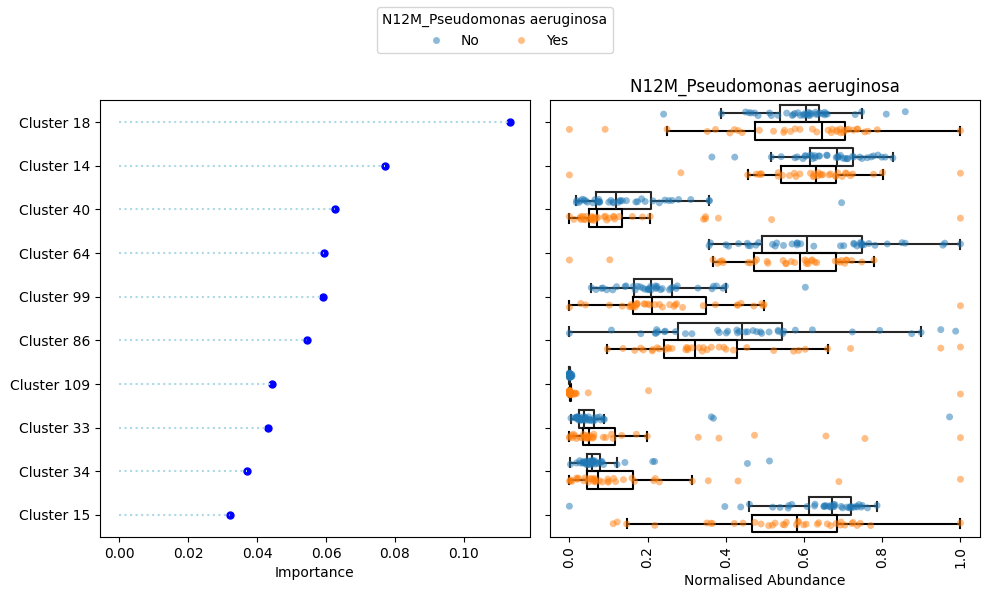

In [14]:
intcol = 'N12M_Pseudomonas aeruginosa'
print(f"'{intcol}' has samples from {metadata.groupby(intcol).size()[1]} pwCF")

n_estimators=1000

# set up our titles and the filename
intcol_title = replace_index.sub('', intcol)
intcol_filename = intcol.replace(" ", "_")

# we limit this to only those samples that ALSO have Pseudomonas, so now we can see if any clusters discriminate regular from MDR Pseudomonas.
merged_df = pc_df.join(metadata[metadata['CS_Pseudomonas aeruginosa'] == 0][intcol], how='inner').dropna(subset=intcol)
print(f"We dropped some rows, so our data has shape {merged_df.shape}", file=sys.stderr)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)
if categorical_data is None:
    print(f"Error: {intcol} is not a numeric or categorical column. Skipped", file=sys.stderr)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

met = None
if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)

y_features = 10
topN = list(feature_importances_sorted[:y_features].index) + [intcol]
fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=2, sharey='row', sharex='col')
cf_analysis_lib.plot_feature_importance(axes[0], feature_importances_sorted[:y_features][::-1], "")
cf_analysis_lib.plot_feature_abundance(axes[1], merged_df[topN][::-1], intcol, intcol_title)

handles, labels = axes[1].get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = labels
try:
    updated_labels = [custom_labels[float(label)] for label in labels]
except Exception as e:
    print(f"Couldn't update labels {e}.", file=sys.stderr)

for ax in axes.flat:
    if ax.get_legend() is not None:  # Check if legend exists
        ax.get_legend().remove()

plt.xticks(rotation=90)
fig.legend(handles, updated_labels, loc='upper center', ncol=2, title=intcol_title)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


## ROC Curve for predicting N12M

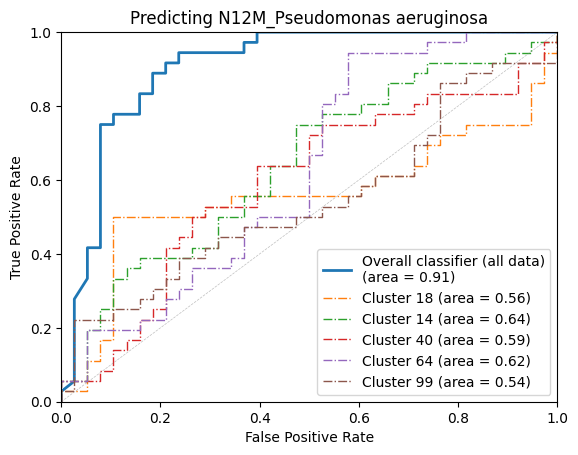

In [15]:
plt = cf_analysis_lib.plot_roc_curves(model, X, y, feature_importances_sorted, met, intcol_title)
plt.show()

'N12M_Pseudomonas aeruginosa' has samples from 71 pwCF


Wrote the new image to pseudomonas/img/clusters_manual/N12M_Pseudomonas_aeruginosa_Cluster_18.png


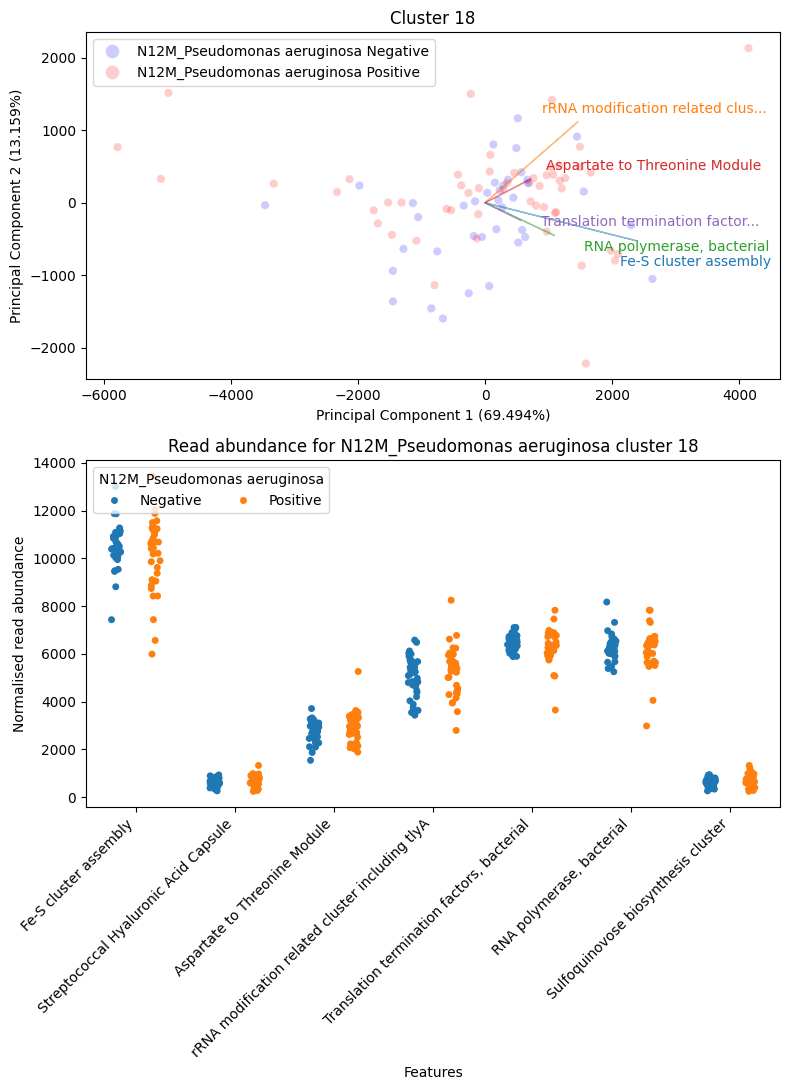

In [16]:
interesting_cluster = 18
print(f"'{intcol}' has samples from {metadata.groupby(intcol).size()[1]} pwCF")

if isinstance(interesting_cluster, int):
    interesting_cluster_filename = f"Cluster_{interesting_cluster}"
elif 'Cluster' in interesting_cluster:
    interesting_cluster_filename = interesting_cluster.replace(" ", "_")
else:
    interesting_cluster_filename = f"Cluster_{interesting_cluster}"
intcol_filename = intcol.replace(" ", "_")
intcol_filename = replace_nonword.sub('', intcol_filename)


# make a new dir so we don't overwrite!
os.makedirs(os.path.join(outdir, "img", "clusters_manual"), exist_ok=True)

pca = PCA(n_components=2)
int_cluster_num = interesting_cluster

df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == int_cluster_num, "Feature"]]
# limit to only those that also have Pseudomonas
merged_df_clust = df_clust.join(metadata[metadata['CS_Pseudomonas aeruginosa'] == 0][intcol], how='inner')
df_clust = merged_df_clust.drop(intcol, axis=1)

pca_result = pca.fit_transform(df_clust)
pca_df = pd.DataFrame(data=pca_result, index=df_clust.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=df_clust.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()

explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]

# don't forget to change the legend
intcol_neg = 0

colours = np.where(merged_df_clust[intcol] == intcol_neg, 'blue', 'red')

# Plot the PCA results
fig, axes = plt.subplots(figsize=(8, 11), nrows=2, ncols=1)
ax = axes[0]
sns.scatterplot(data=pca_df, x='PC1', y='PC2', alpha=0.2, c=colours, ax=ax)
ax.set_title(f"Cluster {interesting_cluster}")
ax.set_xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
ax.set_ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 5
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)


for i in range(maxloadings):
    c = next(colour_cycle)
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    ax.arrow(0, 0, xpos, ypos, 
              color=c, alpha=0.5, width=0.05)
    loading_text = top_loadings_df.index[i]
    if len(loading_text) > 30:
        loading_text = loading_text[:30] + "..."
    texts.append(ax.text(xpos, ypos, loading_text, color=c))

adjust_text(texts, ax=ax)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'{intcol} Negative', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'{intcol} Positive', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
ax.legend(handles=[blue_patch, red_patch])

## Read abundance
ax = axes[1]

df_clust_m = merged_df_clust.melt(id_vars=intcol, var_name='Features', value_name='Normalised read abundance')
df_clust_m = df_clust_m[df_clust_m['Normalised read abundance'] > 0]

cl = {'IP': 'red', 'OP': 'blue'}
g = sns.stripplot(data=df_clust_m, x='Features', y='Normalised read abundance', hue=intcol, dodge=True, jitter=True, ax=ax)
custom_labels = {0: 'Negative', 1: 'Positive'}
handles, labels = g.get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = [custom_labels[float(label)] for label in labels]
g.get_legend().remove()
g.legend(handles, updated_labels, loc='upper left', ncol=2, title=intcol_title)

ax.tick_params(axis='x', rotation=45)
for label in ax.get_xticklabels():
    label.set_horizontalalignment('right')
ax.set_title(f"Read abundance for {intcol} cluster {interesting_cluster}")


plt.tight_layout()
plt.savefig(os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}.png"))
print(f'Wrote the new image to {os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}.png")}', file=sys.stderr)
# Show the plot
plt.show()

# Mucoid or not mucoid Pseudomonas

This _may_ be better off predicting with all data rather than subsystems/families

In [17]:
filtered_md = metadata[(metadata['CS_Pseudomonas aeruginosa'] == 1) & (metadata['CS_mucoid'].astype(int) + metadata['CS_non-mucoid'].astype(int) == 1)][['Pseudomonas Culture', 'CS_Pseudomonas aeruginosa', 'CS_mucoid', 'CS_non-mucoid']]
filtered_md

,Pseudomonas Culture,CS_Pseudomonas aeruginosa,CS_mucoid,CS_non-mucoid
NAME,,,,
1085876_20180227_S,1.0,1,0,1
1128691_20171206_S,1.0,1,1,0
1128691_20171218_S,1.0,1,1,0
1128691_20180116_S,1.0,1,1,0
1316935_20180417_S,1.0,1,1,0
1447437_20171212_S,1.0,1,1,0
1565754_20171128_S,1.0,1,1,0
1565754_20180403_S,1.0,1,1,0
1588281_20180508_S,1.0,1,1,0


'CS_mucoid' has samples from 16 pwCF


We dropped some rows, so our data has shape (26, 151)
Mean squared error for CS_mucoid using classifier is 0.5


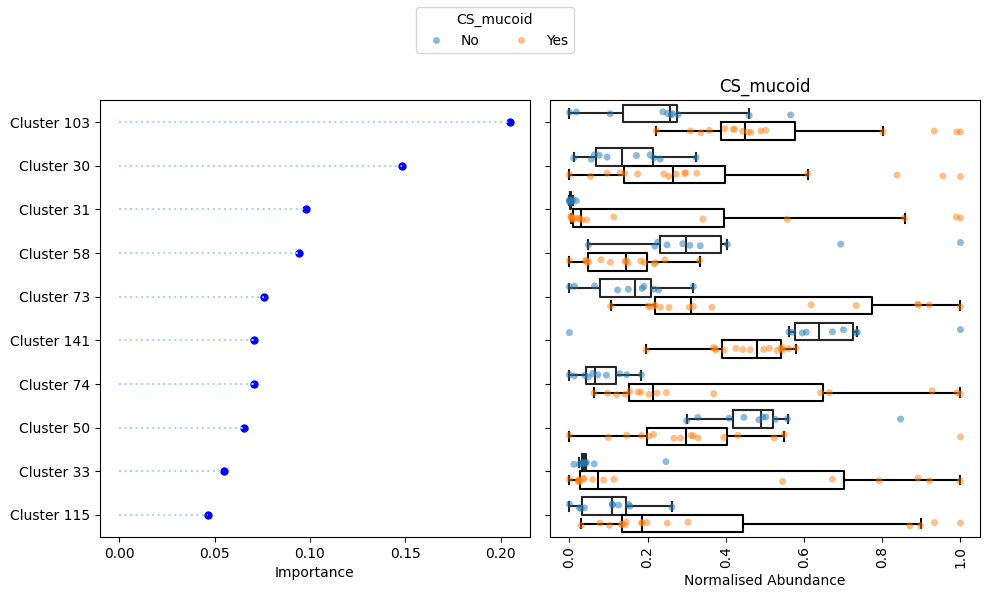

In [18]:
intcol = 'CS_mucoid'
print(f"'{intcol}' has samples from {filtered_md.groupby(intcol).size()[1]} pwCF")

# set up our titles and the filename
intcol_title = replace_index.sub('', intcol)
intcol_filename = intcol.replace(" ", "_")

# we limit this to only those samples that ALSO have Pseudomonas, so now we can see if any clusters discriminate regular from MDR Pseudomonas.
merged_df = pc_df.join(filtered_md[intcol], how='inner').dropna(subset=intcol)
print(f"We dropped some rows, so our data has shape {merged_df.shape}", file=sys.stderr)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)
if categorical_data is None:
    print(f"Error: {intcol} is not a numeric or categorical column. Skipped", file=sys.stderr)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

met = None
if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)

y_features = 10
topN = list(feature_importances_sorted[:y_features].index) + [intcol]
fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=2, sharey='row', sharex='col')
cf_analysis_lib.plot_feature_importance(axes[0], feature_importances_sorted[:y_features][::-1], "")
cf_analysis_lib.plot_feature_abundance(axes[1], merged_df[topN][::-1], intcol, intcol_title)

handles, labels = axes[1].get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = labels
try:
    updated_labels = [custom_labels[float(label)] for label in labels]
except Exception as e:
    print(f"Couldn't update labels {e}.", file=sys.stderr)

for ax in axes.flat:
    if ax.get_legend() is not None:  # Check if legend exists
        ax.get_legend().remove()

plt.xticks(rotation=90)
fig.legend(handles, updated_labels, loc='upper center', ncol=2, title=intcol_title)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


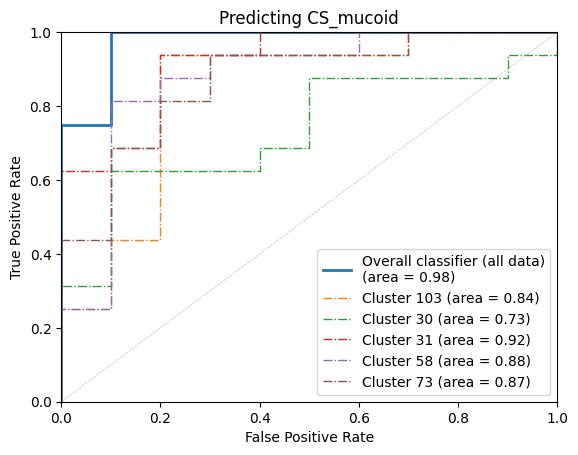

In [19]:
plt = cf_analysis_lib.plot_roc_curves(model, X, y, feature_importances_sorted, met, intcol_title)
plt.show()

'CS_mucoid' has samples from 19 pwCF


1

In [38]:
intcol = 'CS_mucoid'
interesting_cluster = 103
print(f"'{intcol}' has samples from {metadata.groupby(intcol).size()[1]} pwCF")

if isinstance(interesting_cluster, int):
    interesting_cluster_filename = f"Cluster_{interesting_cluster}"
elif 'Cluster' in interesting_cluster:
    interesting_cluster_filename = interesting_cluster.replace(" ", "_")
else:
    interesting_cluster_filename = f"Cluster_{interesting_cluster}"
intcol_filename = intcol.replace(" ", "_")
intcol_filename = replace_nonword.sub('', intcol_filename)


# make a new dir so we don't overwrite!
os.makedirs(os.path.join(outdir, "img", "clusters_manual"), exist_ok=True)

pca = PCA(n_components=2)
int_cluster_num = interesting_cluster

df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == int_cluster_num, "Feature"]]
# limit to only those that also have Pseudomonas
merged_df_clust = df_clust.join(filtered_md[intcol], how='inner')
df_clust = merged_df_clust.drop(intcol, axis=1)

if df_clust.shape[1] > 1:
    pca_result = pca.fit_transform(df_clust)
    pca_df = pd.DataFrame(data=pca_result, index=df_clust.index, columns=['PC1', 'PC2'])
    
    # Get loadings
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings_df = pd.DataFrame(loadings, index=df_clust.columns, columns=['PC1', 'PC2'])
    
    # Create a DataFrame for top loadings
    top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
    top_loadings_df.head()
    
    explained_variance = pca.explained_variance_ratio_ * 100
    pc1_variance = explained_variance[0]
    pc2_variance = explained_variance[1]
    
    # don't forget to change the legend
    intcol_neg = 0
    
    colours = np.where(merged_df_clust[intcol] == intcol_neg, 'blue', 'red')
    
    # Plot the PCA results
    fig, axes = plt.subplots(figsize=(8, 11), nrows=2, ncols=1)
    ax = axes[0]
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', alpha=0.2, c=colours, ax=ax)
    ax.set_title(f"Cluster {interesting_cluster}")
    ax.set_xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
    ax.set_ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')
    
    # add the loadings ... we only plot maxloadings here
    maxloadings = 5
    if len(loadings) < maxloadings:
        maxloadings = len(loadings)
    
    plotscaler = 2
    texts = []
    colour_cycle = cycle(mcolors.TABLEAU_COLORS)
    
    
    for i in range(maxloadings):
        c = next(colour_cycle)
        xpos = top_loadings_df.iloc[i, 0]*plotscaler
        ypos = top_loadings_df.iloc[i, 1]*plotscaler
        ax.arrow(0, 0, xpos, ypos, 
                  color=c, alpha=0.5, width=0.05)
        loading_text = top_loadings_df.index[i]
        if len(loading_text) > 30:
            loading_text = loading_text[:30] + "..."
        texts.append(ax.text(xpos, ypos, loading_text, color=c))
    
    adjust_text(texts, ax=ax)
    
    # Add a legend
    blue_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'{intcol} Negative', 
                             markerfacecolor='blue', alpha=0.2, markersize=10)
    red_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'{intcol} Positive', 
                            markerfacecolor='red', alpha=0.2, markersize=10)
    ax.legend(handles=[blue_patch, red_patch])
    
    ## Read abundance
    ax = axes[1]
    
    df_clust_m = merged_df_clust.melt(id_vars=intcol, var_name='Features', value_name='Normalised read abundance')
    df_clust_m = df_clust_m[df_clust_m['Normalised read abundance'] > 0]
    
    cl = {'IP': 'red', 'OP': 'blue'}
    g = sns.stripplot(data=df_clust_m, x='Features', y='Normalised read abundance', hue=intcol, dodge=True, jitter=True, ax=ax)
    custom_labels = {0: 'Negative', 1: 'Positive'}
    handles, labels = g.get_legend_handles_labels()  # Get one set of handles and labels
    updated_labels = [custom_labels[float(label)] for label in labels]
    g.get_legend().remove()
    g.legend(handles, updated_labels, loc='upper left', ncol=2, title=intcol_title)
    
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')
    ax.set_title(f"Read abundance for {intcol} cluster {interesting_cluster}")
    
    
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}.png"))
    print(f'Wrote the new image to {os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}.png")}', file=sys.stderr)
    # Show the plot
    plt.show()
else:
    print(f"df_clust only has one column {df_clust.columns} so we can't run a PCA", file=sys.stderr)
    print(cluster_assignments.loc[cluster_assignments["Cluster"] == int_cluster_num], file=sys.stderr)

'CS_mucoid' has samples from 19 pwCF


df_clust only has one column Index(['Polyamine Metabolism'], dtype='object') so we can't run a PCA
     Cluster               Feature
694      103  Polyamine Metabolism
